# Cross Validation Groups for Beas and Sutlej data
13th January 2023

In [40]:
import sys
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

In [3]:
sys.path.append('/Users/kenzatazi/Documents/CDT/Code')
from load import beas_sutlej_gauges, era5, data_dir

### Load the data

In [5]:
all_station_dict = pd.read_csv(
    data_dir + 'bs_gauges/gauge_info.csv', index_col='station').T
sta_list = list(all_station_dict)
minyear=1980
maxyear=2010

In [6]:
df_list = []
for station in sta_list:
    station_ds = beas_sutlej_gauges.gauge_download(station, minyear=minyear, maxyear=maxyear)
    df_list.append(station_ds.to_dataframe().dropna().reset_index())
    sta_df = pd.concat(df_list)

/Users/kenzatazi/Documents/CDT/Code/load/beas_sutlej_gauges.py:34: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clean_df.loc[:, 'tp'] = pd.to_numeric(
/Users/kenzatazi/Documents/CDT/Code/load/beas_sutlej_gauges.py:34: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clean_df.loc[:, 'tp'] = pd.to_numeric(
/Users/kenzatazi/Documents/CDT/Code/load/beas_sutlej_gauges.py:34: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df

### Find times with most stations

In [34]:
counts = sta_df.groupby('time').count()
counts.reset_index(inplace=True)

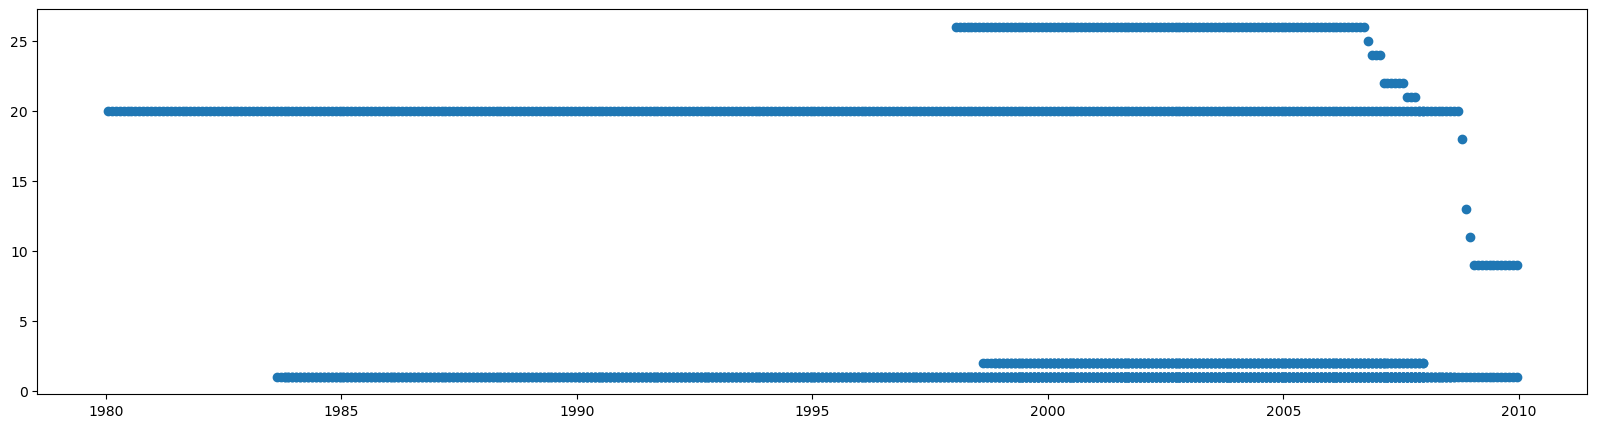

In [43]:
plt.figure(figsize=(20,5))
plt.scatter(counts['time'], counts['lat'])
plt.xlim()

In [51]:
cv_range_df = sta_df[(sta_df['time']>2000) & (sta_df['time']<2005)]

### Apply kmeans

In [85]:
cv_range_df1 = cv_range_df.groupby('z').mean()

In [98]:
cv_range_df1.values[:,2:4]


array([[76.527, 30.994],
       [76.608, 31.087],
       [76.561, 31.204],
       [76.534, 31.233],
       [76.486, 31.25 ],
       [76.404, 31.368],
       [76.385, 31.401],
       [77.625, 30.47 ],
       [77.479, 30.517],
       [76.218, 31.885],
       [76.35 , 31.783],
       [76.417, 31.424],
       [76.503, 31.832],
       [76.55 , 31.4  ],
       [76.762, 31.348],
       [77.437, 30.599],
       [76.708, 31.436],
       [77.108, 31.238],
       [76.622, 31.471],
       [76.878, 31.357],
       [76.554, 31.279],
       [77.473, 30.605],
       [76.933, 31.712],
       [76.519, 31.684],
       [77.164, 31.23 ],
       [76.698, 31.648],
       [77.289, 30.559],
       [76.905, 31.534],
       [77.06 , 31.67 ],
       [77.633, 31.452],
       [77.19 , 31.8  ],
       [77.644, 31.454],
       [76.746, 31.713],
       [77.15 , 31.88 ],
       [76.812, 31.704],
       [76.964, 31.154],
       [77.164, 30.777],
       [77.31 , 31.77 ],
       [76.543, 32.107],
       [76.271, 32.103],


In [99]:
kmeans = KMeans(n_clusters=5).fit(cv_range_df1.values[:, 2:4])

In [100]:
unique, counts = np.unique(kmeans.labels_, return_counts=True)
print(unique, counts)
kmeans.cluster_centers_

[0 1 2 3 4] [16 19  8  8  7]


array([[77.146375  , 31.4868125 ],
       [76.56557895, 31.43468421],
       [76.31475   , 32.33675   ],
       [77.745375  , 31.428875  ],
       [77.36942857, 30.64171429]])

In [109]:
cv_range_df1['fold'] = kmeans.labels_


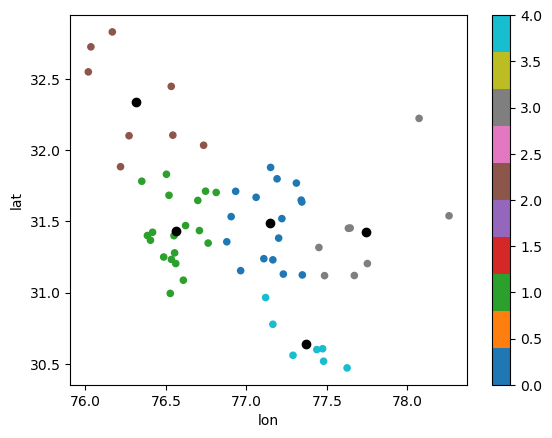

In [110]:
cv_range_df1.plot.scatter(
    x='lon', y='lat', c=cv_range_df1['fold'], cmap='tab10')
plt.scatter(kmeans.cluster_centers_[:, 0],
            kmeans.cluster_centers_[:, 1], c='k')


### Keep cells closest to kmean centers

In [139]:
[euclidean(
        cluster_pts.iloc[idx].values[2:4], cluster_cen) for idx in cluster_pts_indices]

IndexError: single positional indexer is out-of-bounds

In [183]:
from scipy.spatial.distance import euclidean

# Loop over all clusters and find index of closest point to the cluster center and append to closest_pt_idx list.
closest_pt_idx = []
for iclust in range(kmeans.n_clusters):
    # get all points assigned to each cluster:
    cluster_pts = cv_range_df1[cv_range_df1['fold']== iclust]
    # get all indices of points assigned to this cluster:
    cluster_pts_indices = np.where(cluster_pts['fold'] == iclust)[0]

    cluster_cen = kmeans.cluster_centers_[iclust]
    cluster_pts['e_dist'] = [euclidean(
        cluster_pts.iloc[idx].values[2:4], cluster_cen) for idx in cluster_pts_indices]
    cluster_pts.sort_values('e_dist', ignore_index=True, inplace=True)
    closest_pt_idx.append(cluster_pts[['lon', 'lat']].iloc[:7])


/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_5027/4090237644.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_pts['e_dist'] = [euclidean(
/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_5027/4090237644.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_pts.sort_values('e_dist', ignore_index=True, inplace=True)
/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_5027/4090237644.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

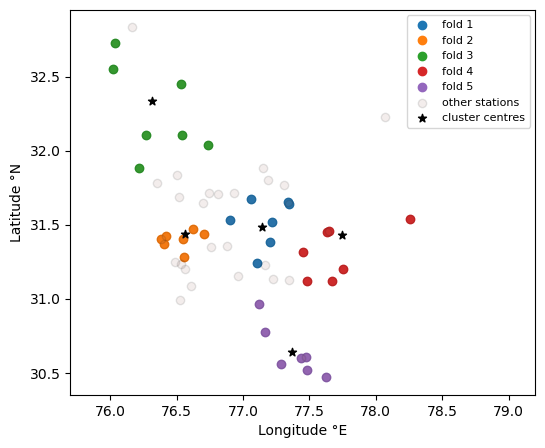

In [168]:
plt.figure(figsize=(6,5))
for i in range(len(closest_pt_idx)):
    plt.scatter(closest_pt_idx[i]['lon'],closest_pt_idx[i]['lat'], label='fold ' + str(i+1))
plt.scatter(cv_range_df1['lon'], cv_range_df1['lat'], edgecolor='k', alpha=0.1,
            zorder=8, label='other stations')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            c='k', marker='*', label='cluster centres')
plt.xlim([75.7, 79.2])
plt.xlabel('Longitude °E')
plt.ylabel('Latitude °N')
plt.legend(fontsize=8)
plt.savefig('Experiment3_CV.png', dpi=300)

In [182]:
# Convert to 3D array and save as .npy
cv_arr = np.array(closest_pt_idx)
print(cv_arr.shape)
np.save('cv_locs.npy', cv_arr)


(5, 7, 2)
